We want to classify images from the CIFAR10 dataset.

It has 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

We use a basic CNN.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the data, Split in valid, test and train set and Apply transform

In [3]:
bs = 4
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#For pretrain model you need to make a transform comatible with the model and close to the one they used

transform_resnet_18 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def build_loaders(transform):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

    train_set,val_set  = torch.utils.data.random_split(trainset, [int(trainset.data.shape[0]*0.8),int(trainset.data.shape[0]*0.2)])

    trainloader = torch.utils.data.DataLoader(train_set, batch_size=bs,
                                              shuffle=True, num_workers=2)

    validloader = torch.utils.data.DataLoader(val_set, batch_size=bs,
                                              shuffle=True, num_workers=2)


    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                             shuffle=False, num_workers=2)
    return [trainloader, validloader, testloader, trainset,  testset]

classes = ('plane', 'car', 'bird', 'cat',
           'mdeer', 'dog', 'frog', 'horse', 'ship', 'truck')
trainloader, validloader, testloader, trainset,  testset = build_loaders(transform)

Files already downloaded and verified
Files already downloaded and verified


# Check distribution of classes in train and test set

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


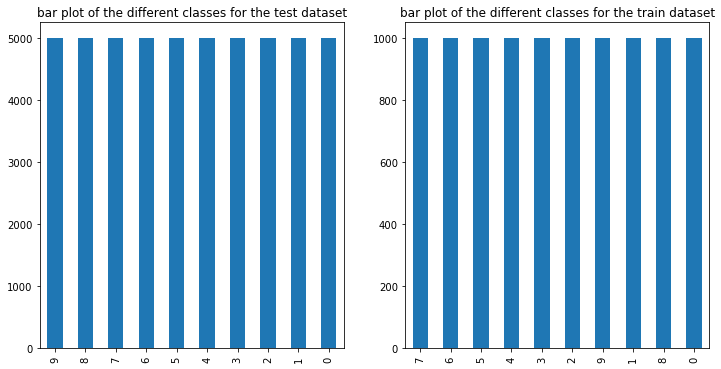

In [4]:
import pandas as pd
print("Classes: " + str(trainset.classes))
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
(pd.Series(trainset.targets)).value_counts().plot.bar(ax = ax1,title='bar plot of the different classes for the test dataset')
out=(pd.Series(testset.targets)).value_counts().plot.bar(ax = ax2, title='bar plot of the different classes for the train dataset')

## Look at some data

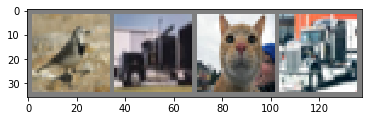

 bird truck   cat truck


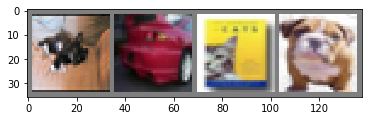

  cat   car   cat   dog


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# get some random training images
dataiter = iter(validloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

 # Create code to train and print the result

In [6]:
def valid_accuracy_loss(net, validloader, criterion):
    correct = 0
    total = 0
    total_loss = 0.0
    
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    final_acc = correct / total
    final_loss= total_loss * 4 / total
    return final_acc, final_loss

def train_model(model, criterion, optimizer, scheduler,
                       num_epochs,file_to_save_res, trainloader, validloader):
    res = pd.DataFrame(columns=['nb_epoch', 'nb_batch', 'train loss', 'valid loss', 'train accuracy', 'valid accuracy'])
    print ('nb_epoch, nb_batch train, loss, valid loss, train accuracy, valid accuracy ')
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        correct = 0.0
        running_loss = 0.0
        tot = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs =  model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
            tot += labels.size(0)
            if i % 2000 == 1999:    # print every 2000 mini-batches
                valid_acc, valid_loss = valid_accuracy_loss(model, validloader, criterion)
                res_new = pd.DataFrame([[epoch + 1, i + 1, running_loss / 2000, valid_loss, correct / tot, valid_acc]], columns = res.columns)
                res = res.append(res_new )                         
                print('%d, %5d %.3f %.3f %.3f %.3f '  %
                      (epoch + 1, i + 1, running_loss / 2000, valid_loss, correct / (2000 * bs), valid_acc))
                running_loss = 0.0
                running_valid_loss = 0.0
                correct = 0.0
                tot = 0.0
                if scheduler != None :
                    scheduler.step()
    res.to_pickle(file_to_save_res)
    print('Finished Training')


## Create a basic neural network for classification of image and train it

In [7]:
import torch.nn as nn
import torch.nn.functional as F
trainloader, validloader, testloader, _,_ = build_loaders(transform)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,8,3)
        self.conv2 = nn.Conv2d(8,16,3)
        self.conv3 = nn.Conv2d(16,32,3)
        self.f1 = nn.Linear(32*5*5, 120)
        self.f2 = nn.Linear(120, 80)
        self.f3 = nn.Linear(80, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32*5*5)
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        out = self.f3(x)
        return out

net1 = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)
train_model(net1, criterion, optimizer, None, 10, 'basic_CNN',trainloader, validloader)

In [8]:
models.resnet18(pretrained=True)

## Create a pretrain neural network for classification of images and train it

In [9]:
criterion = nn.CrossEntropyLoss()
trainloader, validloader, testloader, _,  _ = build_loaders(transform_resnet_18)
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(trainset.classes))
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       3, 'pretrain_CNN_v1', trainloader, validloader)

## Create a pretrain neural network for classification of images and train only the last layer (freeze the others)

In [10]:
criterion = nn.CrossEntropyLoss()
trainloader, validloader, testloader, _,  _ = build_loaders(transform_resnet_18)
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(trainset.classes))
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
train_model(model_conv, criterion, optimizer_ft, exp_lr_scheduler,
                       4, 'pretrainv2', trainloader, validloader)

In [11]:
df_basic_cnn = pd.read_pickle('basic_CNN')
df = df_basic_cnn[['train loss', 'valid loss', 'train accuracy',
       'valid accuracy']].set_index(pd.Series(list(range(1,df_basic_cnn.shape[0]+1))))
df_resnet_18 = pd.read_pickle('pretrain_CNN_v1')
df_resnet_18 = df_resnet_18[['train loss', 'valid loss', 'train accuracy',
       'valid accuracy']].set_index(pd.Series(list(range(1,df_resnet_18.shape[0]+1))))
df_resnet_18_last_layer = pd.read_pickle('pretrainv2')
df_resnet_18_last_layer = df_resnet_18_last_layer[['train loss', 'valid loss', 'train accuracy',
       'valid accuracy']].set_index(pd.Series(list(range(1,df_resnet_18_last_layer.shape[0]+1))))

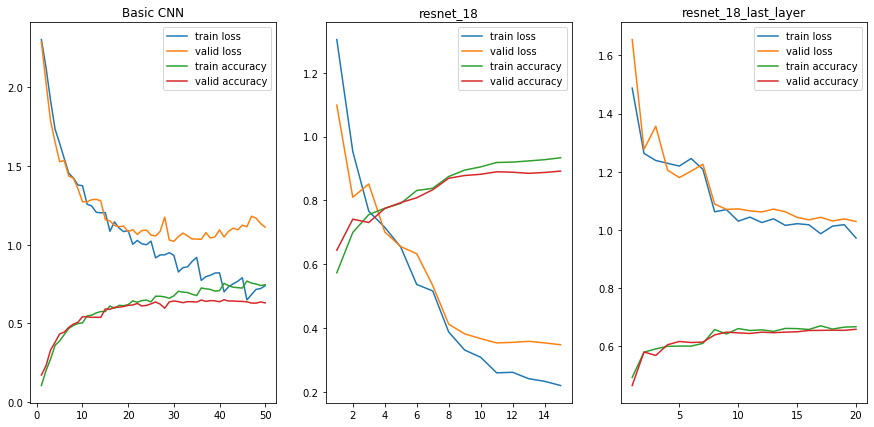

In [12]:
fix, (ax1, ax2, ax3)= plt.subplots(nrows = 1, ncols = 3, figsize=(15,7))
p1 = df.plot.line(title = "Basic CNN", ax = ax1)
p2 = df_resnet_18.plot.line(title = "resnet_18", ax = ax2)
p3 = df_resnet_18_last_layer.plot.line(title = "resnet_18_last_layer", ax = ax3)
plt.show()

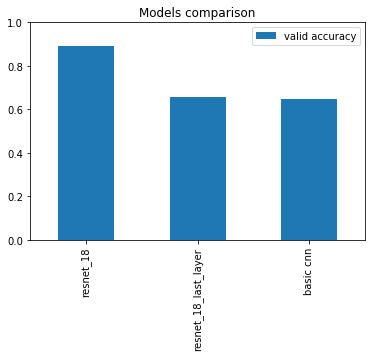

In [13]:
df_basic_cnn_max = df_basic_cnn[df_basic_cnn['valid accuracy']== df_basic_cnn['valid accuracy'].max() ].set_index(pd.Series(["basic cnn"]))
df_resnet_18_max = df_resnet_18[df_resnet_18['valid accuracy']== df_resnet_18['valid accuracy'].max() ].set_index(pd.Series(["resnet_18"]))
df_resnet_18_ll_max = df_resnet_18_last_layer[df_resnet_18_last_layer['valid accuracy']== df_resnet_18_last_layer['valid accuracy'].max() ].set_index(pd.Series(["resnet_18_last_layer"]))
df = df_resnet_18_ll_max.append(df_basic_cnn_max)
df = df_resnet_18_max.append(df)
p_comp = df[['valid accuracy']].plot.bar(ylim=[0,1], title = "Models comparison")
plt.show()